In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-hr.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# select season (zero indexed)
season = 14
df = df[df["season"] == season]
len(df)

7197

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]  # * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]  # * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]  # * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2 / freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes


def get_pitcher_mul(row):
    bm = str(row["batter_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        #         pass # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        #         pass
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #         pass # growth doesn't do anything on pitchers either
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    #         pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        #         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        # On Fire seems to not have an effect here.
        # at *most* it's +0.25 according to our current data, but it could be 0
        mul += 0.25
        pass
    return mul

In [3]:
dfc = df.copy()
dfc["batter_mul"] = dfc.apply(get_batter_mul, axis=1)
dfc["pitcher_mul"] = dfc.apply(get_pitcher_mul, axis=1)

for exclude_mod in []:
    # for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]
pitcher_params = [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]
for attr in batter_params:
    dfc[attr] = dfc[attr] * dfc["batter_mul"]
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * dfc["pitcher_mul"]

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# dfc = dfc[dfc["batter_mul"] == 1]
# dfc = dfc[dfc["pitcher_mul"] == 1]
len(dfc)

7197

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["div_vibes"] = dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2 * dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"])

dfc["opwtimesvibes"] = dfc["pitcher_overpowerment"] * dfc["pitcher_vibes"]
dfc["coldtimesvibes"] = dfc["pitcher_coldness"] * dfc["pitcher_vibes"]
dfc["divtimesvibes"] = dfc["batter_divinity"] * dfc["batter_vibes"]

X = dfc[
    [
        "roll",  #'batter_divinity', 'pitcher_overpowerment', 'pitcher_coldness',
        "div_vibes",
        "opw_vibes",
        "supp_vibes",  # 'divtimesvibes', 'opwtimesvibes', 'coldtimesvibes',
        "ballpark_grandiosity",
        "ballpark_fortification",
        "ballpark_forwardness",
        "ballpark_viscosity",
        "ballpark_ominousness",
    ]
].copy()
y = dfc["passed"]

# X["roll"] = X["roll"] + 0.0725*X["opw_vibes"] + 0.0075*X["supp_vibes"] \
#     + 0.0725*X["ballpark_grandiosity"] + 0.015*X["ballpark_viscosity"] \
#     + 0.0375*X["ballpark_fortification"] - 0.0375*X["ballpark_forwardness"]# \
# #     + 0.015*X["ballpark_ominousness"]
# X = X.drop(["opw_vibes", "ballpark_grandiosity", "ballpark_viscosity", "ballpark_fortification", "ballpark_forwardness", "supp_vibes"], axis=1)


sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=1e10, max_iter=10000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))
confusion_matrix(y, predictionsvm)

5908
1289


array([[5908,    0],
       [   0, 1289]])

In [5]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.16425167]


[(1.0, 'roll'),
 (-0.1592349432018631, 'div_vibes'),
 (0.07270158649708701, 'opw_vibes'),
 (0.07097944124459778, 'ballpark_grandiosity'),
 (-0.04513600992075732, 'ballpark_forwardness'),
 (0.037342685138155224, 'ballpark_fortification'),
 (0.013037418548540932, 'ballpark_viscosity'),
 (0.012086115783443853, 'ballpark_ominousness'),
 (0.00693215516535781, 'supp_vibes')]

In [12]:
fwd = dfc["ballpark_forwardness"]
obt = dfc["ballpark_obtuseness"]
filth = dfc["ballpark_filthiness"]
grand = dfc["ballpark_grandiosity"]
fort = dfc["ballpark_fortification"]
visc = dfc["ballpark_viscosity"]
omin = dfc["ballpark_ominousness"]

div = dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"])

ruth = dfc["pitcher_ruthlessness"] * (1 + 0.2 * dfc["pitcher_vibes"])
opw = dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"])
supp = dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"])

# dfc["threshold"] = 0.1464 + 0.16*div - 0.0743*opw - 0.0725*grand + 0.049*fwd - 0.0332*fort

dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        if "sq" in pair[1]:
            print(np.sqrt(pair[0]))
        dfc["threshold"] += pair[0] * dfc[pair[1]]

# dfc['threshold'] = 0.167 + 0.159*div - 0.072*opw - 0.008*supp
# dfc['threshold'] += - 0.074*grand - 0.0375*fort + 0.0425*fwd - 0.012*visc - 0.01*omin


# dfc["threshold"] = 0.159bu + 0.158*div - 0.0725*opw - 0.0075*supp - 0.075*grand - 0.038*fort + 0.05*fwd - 0.008*visc
# dfc["threshold"] = 0.165 + 0.159*div - 0.0724*opw - 0.008*supp - 0.0724*grand - 0.039*fort + 0.039*fwd - 0.014*visc

# dfc["threshold"] = 0.165 + 0.159*div - 0.0724*opw - 0.008*supp - 0.0724*grand - 0.039*fort + 0.039*fwd - 0.014*visc
# dfc["threshold"] = 0.16 + 0.165*div - 0.0725*opw - 0.008*supp - 0.0725*grand - 0.04*fort + 0.04*fwd - 0.0139*visc
coefsum = -0.074 - 0.0375 + 0.0425 - 0.012 - 0.01
print(round(coefsum, 6))
print(round(0.5 * coefsum, 6))
print("", 0.167)
print("", round(0.5 * coefsum + 0.167, 6))

[0.16425167]
(0.1592349432018631, 'div_vibes')
(-0.07270158649708701, 'opw_vibes')
(-0.00693215516535781, 'supp_vibes')
(-0.07097944124459778, 'ballpark_grandiosity')
(-0.037342685138155224, 'ballpark_fortification')
(0.04513600992075732, 'ballpark_forwardness')
(-0.013037418548540932, 'ballpark_viscosity')
(-0.012086115783443853, 'ballpark_ominousness')
-0.091
-0.0455
 0.167
 0.1215


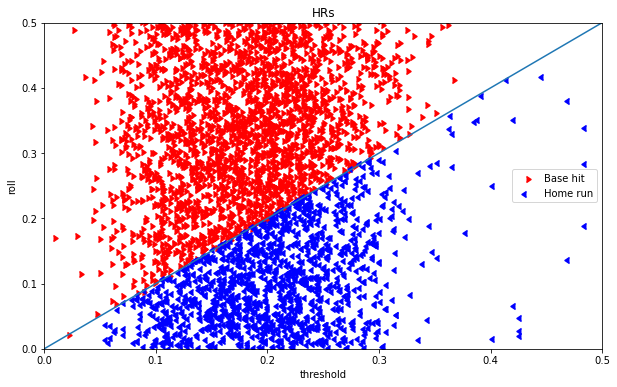

In [13]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Base hit",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Home run",
    marker=CARETLEFTBASE,
)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("HRs")
ax.set_xlim([0.0, 0.5])
ax.set_ylim([0.0, 0.5])
ax.legend()

0


,offset,weather,event_type,roll,threshold,div_vibes,opw_vibes,supp_vibes,baserunner_count,batter_name,pitcher_name,batter_mods,pitcher_mods,batter_mul,pitcher_mul,batting_team_mods,pitching_team_mods,day,game_id,play_count


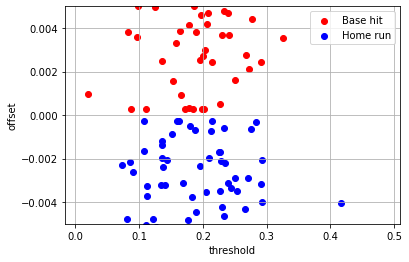

In [14]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[
    (dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))
]

fig, ax = plt.subplots(1)
x_val = "threshold"
y_val = "offset"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Base hit")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Home run")
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Base hit",
)
ax.scatter(
    dfc[dfc["passed"]][x_val], dfc[dfc["passed"]][y_val], color="blue", label="Home run"
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()
print(len(outliers))
table = outliers
# ax.set_yscale("log")
ax.set_ylim(-0.5e-2, 0.5e-2)
ax.grid()
# fig.savefig("hr_fit_offsets_1.png", facecolor='white')
table[
    [
        "offset",
        "weather",
        "event_type",
        "roll",
        "threshold",
        "div_vibes",
        "opw_vibes",
        "supp_vibes",
        "baserunner_count",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batter_mul",
        "pitcher_mul",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset")

In [15]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.4166500940357283
0.0210606111139923


In [10]:
table.groupby("pitching_team_mods").size()

pitching_team_mods
HIGH_PRESSURE                            1
LIFE_OF_PARTY;ELECTRIC                   1
MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS    1
POPCORN_PAYOUTS                          1
SINKING_SHIP                             1
TRAVELING                                1
dtype: int64

In [18]:
dfc.loc[
    7148,
    [
        "offset",
        "weather",
        "event_type",
        "roll",
        "threshold",
        "div_vibes",
        "opw_vibes",
        "supp_vibes",
        "baserunner_count",
        "batter_vibes",
        "pitcher_vibes",
        "batter_divinity",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batter_mul",
        "pitcher_mul",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
    ],
]

KeyError: 7148